In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# drop columns with unique value in train
for k in train.keys():
    if len(train[k].unique()) == 1:
        train.pop(k)
        test.pop(k)
print("Train shape : ", train.shape)

('Train shape : ', (4209, 366))


In [4]:
# drop the outliers
index = train.y.values < 250
train = train[index]
print("Train shape : ", train.shape)

('Train shape : ', (4208, 366))


In [5]:
y = train["y"]
train = train.drop("y", axis=1)
X = pd.concat([train, test], axis=0)
num_train = train.shape[0]
print("X shape : ", X.shape)

('X shape : ', (8417, 365))


In [6]:
dv = DictVectorizer()
X_dv = dv.fit_transform(X.to_dict(orient = 'records')).toarray()
print("X_dv shape : ", X_dv.shape)

('X_dv shape : ', (8417, 568))


In [10]:
sfs = SFS(LinearRegression(),
              k_features=50,
              forward=True,
              floating=False,
              verbose=0,
              scoring='r2',
#              n_jobs=6,
              cv=5)
sfs.fit(X_dv[:num_train], y)

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
             floating=False, forward=True, k_features=50, n_jobs=1,
             pre_dispatch='2*n_jobs', scoring='r2', skip_if_stuck=True,
             verbose=0)

In [12]:
print sfs.k_score_
col_index = sfs.k_feature_idx_
print col_index
sfs_df = X_dv[:,col_index]
print("sfs_df shape : ", sfs_df.shape)

0.608882005172
(129, 514, 534, 519, 10, 13, 271, 22, 24, 30, 31, 35, 422, 552, 42, 455, 45, 221, 287, 49, 179, 542, 443, 189, 53, 192, 352, 435, 71, 72, 336, 7, 15, 92, 349, 479, 480, 353, 327, 484, 294, 232, 489, 107, 488, 244, 120, 506, 125, 511)
('sfs_df shape : ', (8417, 50))


In [13]:
##Add decomposed components: PCA / ICA etc.
from sklearn.decomposition import PCA, FastICA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp, random_state=123)
pca_df = pca.fit_transform(X_dv)

# ICA
ica = FastICA(n_components=n_comp, random_state=321)
ica_df = ica.fit_transform(X_dv)   

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
tsne_df = tsne.fit_transform(X_dv)
print("tsne_df shape : ", tsne_df.shape)

('tsne_df shape : ', (8417, 3))


In [15]:
stack_df = np.column_stack((sfs_df, pca_df, ica_df, tsne_df))
print("stack_df shape : ", stack_df.shape)

('stack_df shape : ', (8417, 73))


In [23]:
lr = LinearRegression()
lr.fit(sfs_df[:num_train], y)
pred = lr.predict(sfs_df[num_train:])

In [28]:
out = pd.DataFrame({'ID': test.ID, 'y': pred})
out.to_csv('lr_sfs50cv5.csv', index=False)
#out.head(20)

In [26]:
lr = LinearRegression()
lr.fit(stack_df[:num_train], y)
pred = lr.predict(stack_df[num_train:])

In [29]:
out = pd.DataFrame({'ID': test.ID, 'y': pred})
out.to_csv('lr_sfs50cv5_pca_ica_tnse.csv', index=False)
#out.head(20)

In [78]:
from sklearn.metrics import r2_score
import xgboost as xgb
from scipy.sparse import csr_matrix

def xgb_r2(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', -r2_score(labels, preds) # 

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(csr_matrix(stack_df[:num_train]), label=np.array(y))
dtest = xgb.DMatrix(csr_matrix(stack_df[num_train:]))

# prepare dict of params for xgboost to run with
xgb_params = {
    'eta': 0.005,
    'max_depth': 4,
    'objective': 'reg:linear'
}

cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=2000, # increase to have better results (~700)
                   early_stopping_rounds=20,
                   feval=xgb_r2,
                   verbose_eval=100, 
                   nfold=5,
                   show_stdv=False
                  )

[0]	train-r2:64.3819	test-r2:64.5988
[100]	train-r2:23.2871	test-r2:23.367
[200]	train-r2:8.18412	test-r2:8.21491
[300]	train-r2:2.62986	test-r2:2.64644
[400]	train-r2:0.579728	test-r2:0.599538
[500]	train-r2:-0.180715	test-r2:-0.154318
[600]	train-r2:-0.466141	test-r2:-0.43069
[700]	train-r2:-0.577475	test-r2:-0.531662
[800]	train-r2:-0.623168	test-r2:-0.568157
[900]	train-r2:-0.644398	test-r2:-0.580898
[1000]	train-r2:-0.656651	test-r2:-0.584588
[1100]	train-r2:-0.665	test-r2:-0.585179


1086


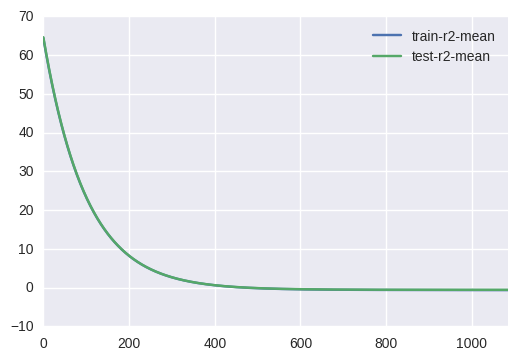

In [79]:
cv_result[['train-r2-mean', 'test-r2-mean']].plot()

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

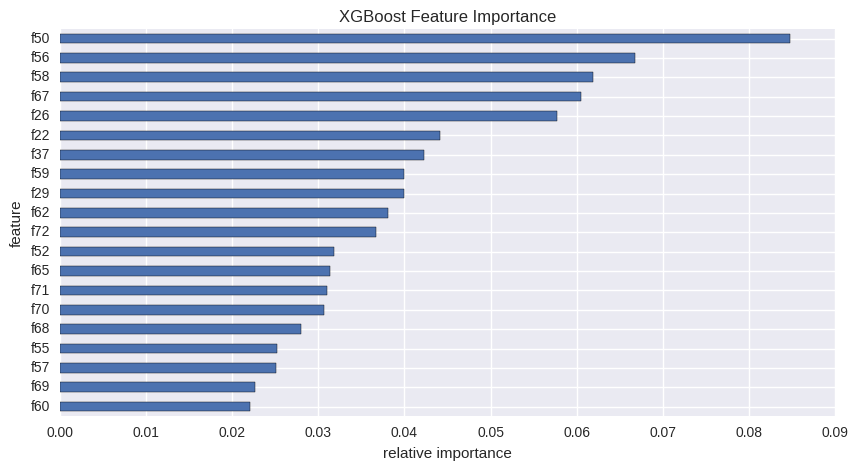

In [80]:
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)

import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [81]:
xgb_r2(model.predict(dtrain), dtrain)

('r2', -0.65842686143254592)

In [82]:
# make predictions and save results
y_pred = model.predict(dtest)

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgb_sfs50cv5_pca_ica_tnse.csv', index=False)

In [85]:
stack_ID = np.column_stack((stack_df, np.array(X["ID"])))
print stack_ID.shape

(8417, 74)


In [86]:
# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(csr_matrix(stack_ID[:num_train]), label=np.array(y))
dtest = xgb.DMatrix(csr_matrix(stack_ID[num_train:]))

# prepare dict of params for xgboost to run with
xgb_params = {
    'eta': 0.005,
    'max_depth': 4,
    'objective': 'reg:linear'
}

cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=2000, # increase to have better results (~700)
                   early_stopping_rounds=20,
                   feval=xgb_r2,
                   verbose_eval=100, 
                   nfold=5,
                   show_stdv=False
                  )

[0]	train-r2:64.3819	test-r2:64.5988
[100]	train-r2:23.2871	test-r2:23.367
[200]	train-r2:8.18412	test-r2:8.21491
[300]	train-r2:2.62986	test-r2:2.64644
[400]	train-r2:0.579719	test-r2:0.599596
[500]	train-r2:-0.180756	test-r2:-0.154303
[600]	train-r2:-0.466307	test-r2:-0.430565
[700]	train-r2:-0.577453	test-r2:-0.531756
[800]	train-r2:-0.622966	test-r2:-0.568425
[900]	train-r2:-0.644188	test-r2:-0.581276
[1000]	train-r2:-0.656198	test-r2:-0.585008
[1100]	train-r2:-0.664686	test-r2:-0.585736


1096


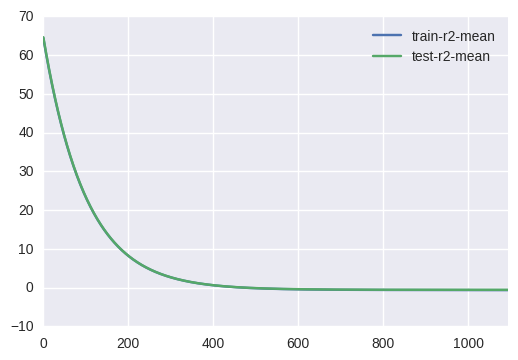

In [87]:
cv_result[['train-r2-mean', 'test-r2-mean']].plot()

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

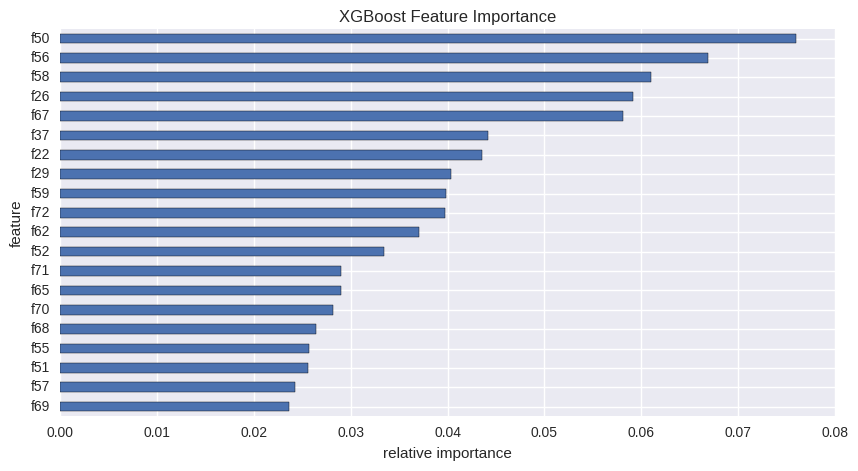

In [88]:
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)

import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [89]:
xgb_r2(model.predict(dtrain), dtrain)

('r2', -0.65681133341681963)

In [90]:
# make predictions and save results
y_pred = model.predict(dtest)

output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgb_sfs50cv5_pca_ica_tnse_ID.csv', index=False)

In [91]:
xgb1 = pd.read_csv('xgb_sfs50cv5_pca_ica_tnse.csv')
xgb2 = pd.read_csv('xgb_sfs50cv5_pca_ica_tnse_ID.csv')

xgb2['y'] = xgb2.y * 0.5 + xgb1.y * 0.5
xgb2.to_csv('mix.csv', index=False)

In [92]:
xgb1.describe()

,id,y
count,4209.000000,4209.000000
mean,4211.039202,100.499302
std,2423.078926,9.324810
min,1.000000,76.904465
25%,2115.000000,93.796295
50%,4202.000000,95.147209
75%,6310.000000,110.972260
max,8416.000000,121.830994


In [93]:
xgb2.describe()

,id,y
count,4209.000000,4209.000000
mean,4211.039202,100.502813
std,2423.078926,9.325562
min,1.000000,76.880051
25%,2115.000000,93.804768
50%,4202.000000,95.070404
75%,6310.000000,110.956436
max,8416.000000,122.016552


In [102]:
xgb1 = pd.read_csv('submission_baseLine_or.csv')
LR = pd.read_csv('LR_original.csv')

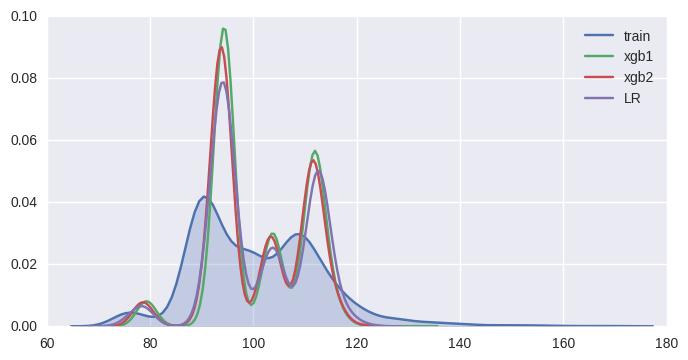

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(8,4))
sns.kdeplot(y, shade=True, label="train")
sns.kdeplot(xgb1.y, shade=False, label="xgb1")
sns.kdeplot(xgb2.y, shade=False, label="xgb2")
sns.kdeplot(LR.y, shade=False, label="LR")